In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd  
import numpy as np
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from adjustText import adjust_text
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

### Get the US County Polygon Data from the Census

In [3]:
county_shapes = gpd.read_file("/Users/nelsonfarrell/Documents/Northeastern/projects/hospital_beds/gis_data/cb_2023_us_county_500k.zip")

### Filter for Maine Counties

In [4]:
maine_counties = county_shapes[county_shapes.STATE_NAME == "Maine"].copy()

In [5]:
maine_counties.rename(columns = {"NAME":"county"}, inplace = True )

### Display Maine County Map

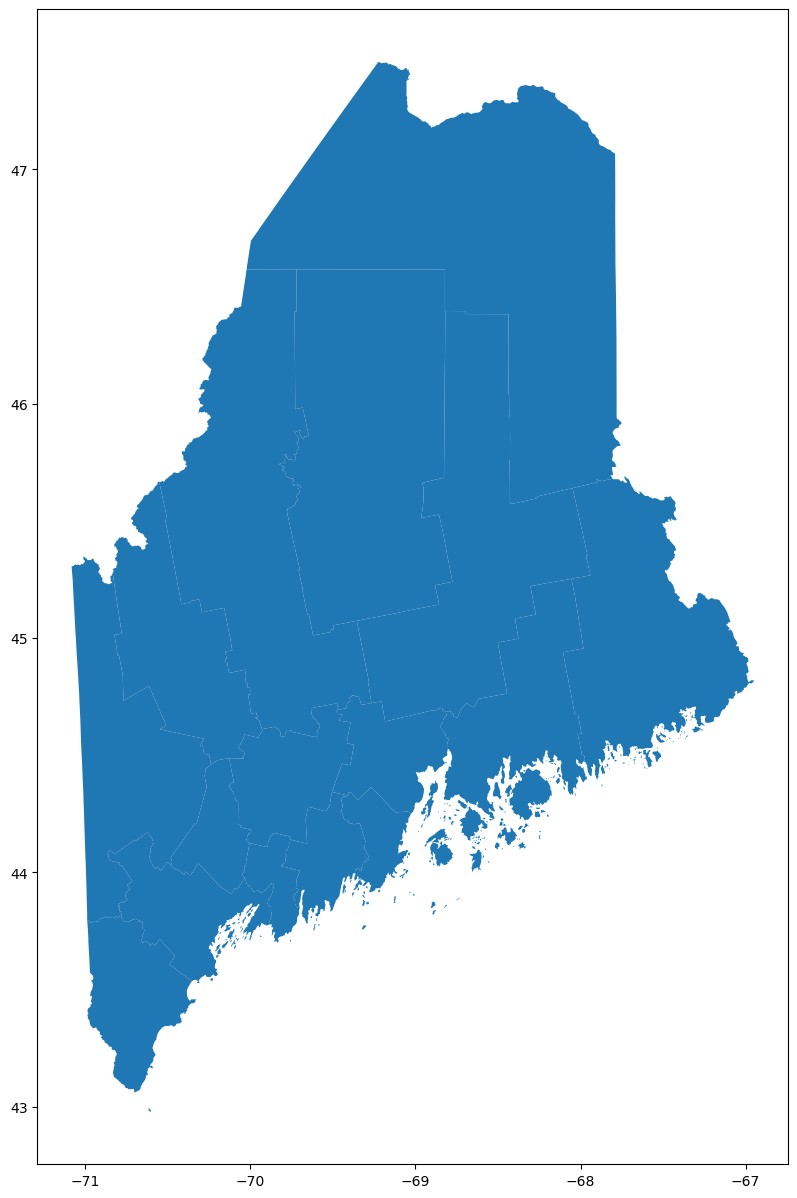

In [6]:
maine_counties.plot(figsize = (10, 15));

### Generate Regoin Mapping ~ Groups of Counties

In [7]:
region_map = {
                "Cumberland County" : 1,
                "York County" : 1,
                "Oxford County" : 2,
                "Kennebec County" : 3,
                "Knox County" : 4,
                "Lincoln County" : 4,
                "Somerset County": 3,
                "Washington County" : 7,
                "Hancock County" : 7,
                "Waldo County" : 4,
                "Penobscot County" : 6,
                "Aroostook County" : 5,
                "Piscataquis County" : 6,
                "Sagadahoc County" : 4,
                "Androscoggin County" : 3,
                "Franklin County": 2
              }

region_colors = {
                    1 : '#85c1e9',  # Light Blue
                    2 : '#c39bd3',  # Light Purple
                    3 : '#a3e4d7', # Light Green
                    4 : '#7dcea0',  # Light Red
                    5 : '#f8c471', # Light Orange
                    6 : "#f1948a", # Light Grey
                    7 : "#edbb99" # Light orange
                }

### Set Matplotlib Params & Color Mappings

In [110]:
# Update rcParams
gray="#f0f1f5" 
blue="#436ca9"
light_blue="#94aacd"
brown="#cf9f51"                    
title_weight="bold"
tick_direction="out"

plt.rcParams.update({
        # Figure and Axes Background
        'figure.figsize': (10, 6),              # Default figure size
        'figure.dpi': 100,                      # DPI for the figure
        'figure.facecolor': gray,          # Figure background color
        'axes.facecolor': gray,             # Axes background color
        'figure.labelweight': 'bold',

        # Titles and Labels
        'axes.titlesize': 18,                   # Title font size
        'figure.titlesize': 18,
        'figure.titleweight': 'bold',  # Font weight
        'figure.subplot.top': 0.9,  # Controls the overall top spacing of subplots
        'axes.titleweight': 'heavy',             # Title font weight
        'axes.labelweight': 'bold',             
        'axes.labelsize': 14,                   # Axes labels font size
        'axes.labelcolor': blue,           # Axes labels color
        'axes.titlepad': 20,

        # Tick Parameters
        'xtick.labelsize': 12,                  # X-tick labels font size
        'ytick.labelsize': 12,                  # Y-tick labels font size
        'xtick.color': blue,               # X-tick color
        'ytick.color': blue,               # Y-tick color
        'xtick.direction': 'out',               # X-tick direction
        'ytick.direction': 'out',               # Y-tick direction
        'xtick.major.size': 12,                 # X-tick major size
        'ytick.major.size': 12,                 # Y-tick major size

        # Grid and Spines
        'axes.grid': False,                      # Enable grid by default
        'grid.alpha': 0.7,                      # Grid transparency
        'grid.color': brown,                # Grid color
        'axes.spines.top': False,               # Hide top spine
        'axes.spines.right': False,             # Hide right spine
        'axes.edgecolor': brown,            # Color of axis edges

        # Lines and Markers
        'lines.linewidth': 1,                   # Default line width
        'lines.markersize': 4,                  # Default marker size
        'lines.marker': 'o',                    # Default marker style

        # Legend
        'legend.fontsize': 12,                  # Legend font size
        'legend.title_fontsize': 12,            # Legend title font size
        'legend.frameon': True,                 # Add a border/frame to legend
        'legend.framealpha': 0.8,               # Legend background transparency
        'legend.edgecolor': "#e8e0c5",          # Legend edge color

        # Fonts
        'font.family': 'sans-serif',            # Default font family
        'font.sans-serif': 'Helvetica Neue',    # Preferred sans-serif font

        # Save Figure Defaults
        'savefig.dpi': 300,                     # DPI for saving figures
        'savefig.format': 'png',                # Default save format
        'savefig.bbox': 'tight',                # Ensure tight bounding box for saved plots
    })


facility_colors={
    'Home Health': '#1f77b4',                        # Blue
    'Skilled Nursing Facility (SNF)': '#ff7f0e',     # Orange
    'Long Term Care Hospital (LTC)': '#2ca02c',      # Green
    'Residential Care Facility (RCF)': '#d62728',    # Red
}

facility_colors_acronym ={
    'HH': '#1f77b4',                        # Blue
    'SNF': '#ff7f0e',     # Orange
    'LTC': '#2ca02c',      # Green
    'RCF': '#d62728',    # Red
}

["SNF", "LTC", "RCF", "HH"]

sublte_colors = [
    "#6F8FAF", "#A3C4BC", "#E6B8A2", "#D8A7CA", "#FFCCBC",
    "#D3ECA7", "#F1DCA7", "#BFD3C1", "#E4C1F9", "#A1C3D1",
    "#D4A5A5", "#A8D5BA", "#EAD2AC", "#B4A0E5", "#C2C2F0"
]

vivid_colors = [
    "#4C72B0",  # Vivid Steel Blue
    "#DD8452",  # Warm Orange
    "#55A868",  # Vibrant Green
    "#C44E52",  # Bright Red
    "#8172B3",  # Deep Lavender
    "#937860",  # Rich Taupe
    "#DA8BC3",  # Vibrant Pink
    "#8C8C8C",  # Neutral Gray
    "#E1B12C",  # Vivid Yellow
    "#2A9D8F",  # Teal Green
    "#F4A261",  # Bright Peach
    "#E76F51",  # Burnt Orange
    "#F94144",  # Vivid Coral Red
    "#577590",  # Deep Slate Blue
    "#90BE6D"   # Soft Lime Green
]

county_colors = {
    "Cumberland County": '#85c1e9',  # Light Blue
    "York County": '#c39bd3',        # Light Purple
    "Oxford County": '#a3e4d7',      # Light Green
    "Kennebec County": '#ffcccb',    # Light Red
    "Knox County": '#d3d3d3',        # Light Grey
    "Lincoln County": '#f7dc6f',     # Light Yellow
    "Somerset County": '#5ddfce',    # Light Teal
    "Washington County": '#ea8cea',  # Light Pink
    "Hancock County": '#f9e79f',     # Light Beige
    "Waldo County": '#aed6f1',       # Soft Blue
    "Penobscot County": '#d5a6bd',   # Soft Pink
    "Aroostook County": '#abebc6',   # Soft Green
    "Piscataquis County": '#fad7a0', # Soft Peach
    "Sagadahoc County": '#bb8fce',   # Soft Lavender
    "Androscoggin County": '#f5b7b1', # Soft Coral
    "Franklin County": '#f8c471'     # Soft Orange
}


### Update ```maine_counties_df```  
* Add ```region``` column
* Add color columns for regions and counties

In [9]:
maine_counties.loc[:, "region"] = maine_counties["NAMELSAD"].map(region_map)
maine_counties.loc[:, "region_color"] = maine_counties["region"].map(region_colors)

In [10]:
maine_counties["color"] = maine_counties["NAMELSAD"].map(county_colors)

In [11]:
maine_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,county,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,region,region_color,color
51,23,015,00581293,0500000US23015,23015,Lincoln,Lincoln County,ME,Maine,06,1180688993,631299424,"MULTIPOLYGON (((-69.32357 43.75899, -69.32114 ...",4,#7dcea0,#f7dc6f
52,23,017,00581294,0500000US23017,23017,Oxford,Oxford County,ME,Maine,06,5379294383,255884970,"POLYGON ((-71.08000 45.30699, -71.07841 45.306...",2,#c39bd3,#a3e4d7
195,23,023,00581297,0500000US23023,23023,Sagadahoc,Sagadahoc County,ME,Maine,06,657801805,300571247,"MULTIPOLYGON (((-69.76031 43.71044, -69.75904 ...",4,#7dcea0,#bb8fce
432,23,027,00581299,0500000US23027,23027,Waldo,Waldo County,ME,Maine,06,1890642742,317988397,"MULTIPOLYGON (((-68.94229 44.28436, -68.94063 ...",4,#7dcea0,#aed6f1
435,23,025,00581298,0500000US23025,23025,Somerset,Somerset County,ME,Maine,06,10163811939,437942552,"POLYGON ((-70.55279 45.66784, -70.54730 45.666...",3,#a3e4d7,#5ddfce
541,23,021,00581296,0500000US23021,23021,Piscataquis,Piscataquis County,ME,Maine,06,10258545867,1080517302,"POLYGON ((-69.83118 45.73860, -69.82943 45.738...",6,#f1948a,#fad7a0
710,23,031,00581301,0500000US23031,23031,York,York County,ME,Maine,06,2567186511,721352437,"MULTIPOLYGON (((-70.61725 42.99202, -70.61467 ...",1,#85c1e9,#c39bd3
911,23,007,00581289,0500000US23007,23007,Franklin,Franklin County,ME,Maine,06,4395226704,121284631,"POLYGON ((-70.83554 45.29380, -70.82755 45.296...",2,#c39bd3,#f8c471
1287,23,003,00581287,0500000US23003,23003,Aroostook,Aroostook County,ME,Maine,06,17278162809,405078327,"POLYGON ((-70.01975 46.59217, -69.99709 46.695...",5,#f8c471,#abebc6
1925,23,019,00581295,0500000US23019,23019,Penobscot,Penobscot County,ME,Maine,06,8798661091,414021728,"POLYGON ((-69.35567 45.07347, -69.24996 45.087...",6,#f1948a,#d5a6bd


### Plot Regions

/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_59754/3462984783.py:4: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  maine_counties.plot(column='region',


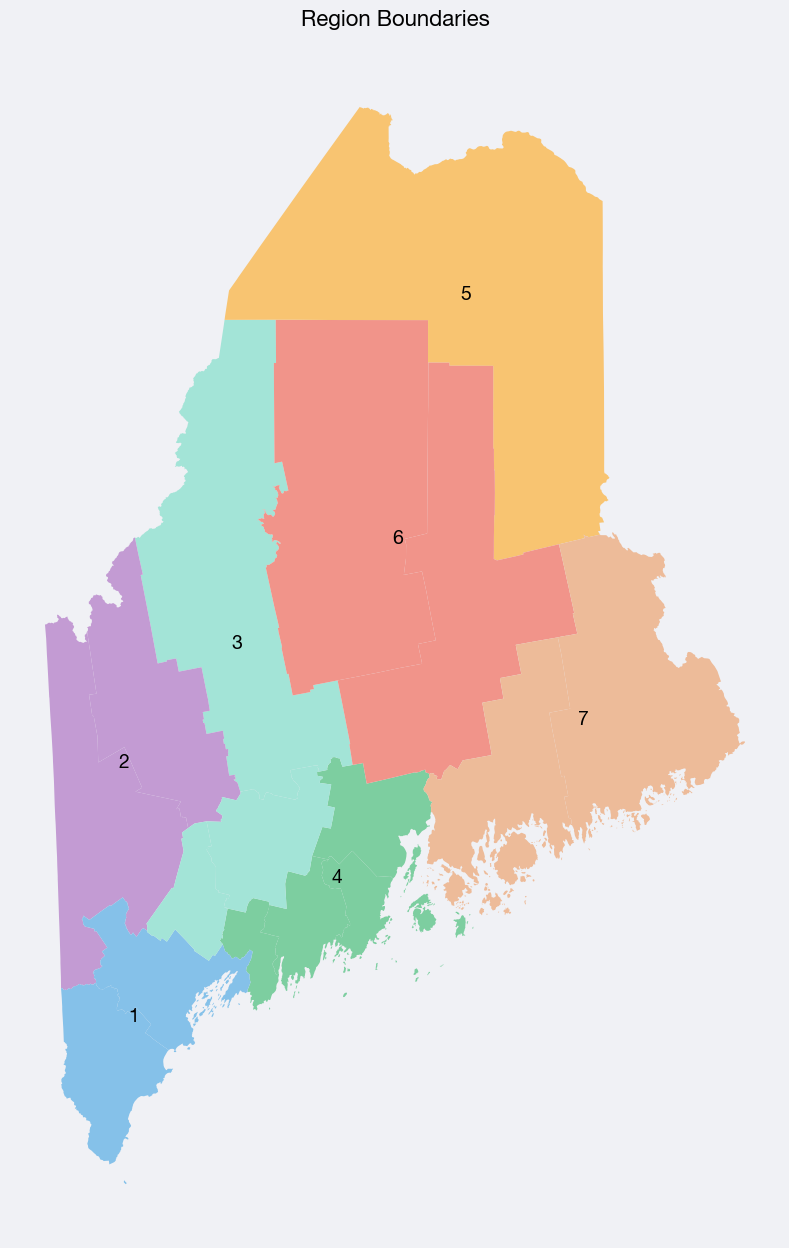

In [12]:
# Plot the map, coloring by region
fig, ax = plt.subplots(figsize=(10, 15))

maine_counties.plot(column='region', 
                   color = maine_counties["region_color"],  
                   legend = True,   
                   figsize=(10, 15),
                   ax = ax)

# This changes the borders from county to region; the agg function makes it keep only one of the values,
# rather than a sum. Since grouped_df already contains region totals, this is accurate.
region_geometries = maine_counties.dissolve(by='region').reset_index()

# Display totals in the center of the region
for idx, row in region_geometries.iterrows():
    if not pd.isna(row['region']):  

        # Get the center of the region
        centroid = row['geometry'].centroid
        x, y = centroid.x, centroid.y
        ax.text(
            x, y,
            f"{int(row['region'])}",
            ha="center", fontsize=14, color = "black", weight="bold"
        )   
ax.axis("off")
plt.title("Region Boundaries", weight = "bold", fontsize = 16)
fig.savefig("../figs/region_definitions.png", dpi = 300, bbox_inches="tight")
plt.show()


### Read In Hospital Response Data

In [43]:
response_data_full = pd.read_csv("/Users/nelsonfarrell/Documents/Northeastern/projects/hospital_beds/survey_data/CSV/response_data_clean.csv")

In [44]:
response_data_full.shape

(25, 161)

### Get Hospital Names & Addresses

In [45]:
response_data_full.loc[:, ["hospital_name", "hospital_address", "Is your facility designated a Critical Access Hospital? Response"]]

,hospital_name,hospital_address,Is your facility designated a Critical Access Hospital? Response
0,Central Maine Medical Center,"300 Main Street, Lewiston, ME 04240)",No
1,Penobscot Valley Hospital,"7 Transalpine Road, P.O. Box 368, Lincoln, ME ...",Yes
2,Franklin Memorial Hospital,"111 Franklin Health Commons, Farmington, ME 04938",Yes
3,Northern Light Mayo Hospital,"897 West Main Street, Dover-Foxcroft, ME 04426)",Yes
4,Rumford Hospital,"420 Franklin Street, Rumford, ME 04276)",Yes
5,Millinocket Regional Hospital,"200 Somerset Street, Millinocket, ME 04462)",Yes
6,Northern Light Acadia Hospital,"P.O. Box 422, 268 Stillwater Avenue, Bangor, M...",NaN
7,Pen Bay Medical Center,"Six Glen Cove Drive, Rockport, ME 04856)",No
8,Waldo County General Hospital,"118 Northport Avenue, P.O. Box 287, Belfast, M...",Yes
9,York Hospital,"15 Hospital Drive, York, ME 03909)",No


In [46]:
response_data = response_data_full[["hospital_name", "hospital_address", "Is your facility designated a Critical Access Hospital? Response"]].copy()

In [48]:
response_data.loc[6, "Is your facility designated a Critical Access Hospital? Response"] = "No"

In [60]:
hospital_and_crit_access = response_data.iloc[:, [0,2]]

In [61]:
# First we have to remove this dumb parenthesis 
response_data["hospital_address"] = response_data["hospital_address"].str.rstrip(')')

# And the PO Box info, this messes up the geolocate function
response_data["hospital_address"] = response_data["hospital_address"].str.replace(r'P\.O\. Box \d+, ', '', regex=True)

### Inspect Hospital Name and Addresses

In [62]:
addresses = response_data.loc[:, "hospital_address"]
names = response_data.loc[:, "hospital_name"]
x = 1
for name, address in zip(names, addresses):
    print(f"{x}: {name} ---- {address}")
    x+=1

1: Central Maine Medical Center ---- 300 Main Street, Lewiston, ME 04240
2: Penobscot Valley Hospital ---- 7 Transalpine Road, Lincoln, ME 04457
3: Franklin Memorial Hospital ---- 111 Franklin Health Commons, Farmington, ME 04938
4: Northern Light Mayo Hospital ---- 897 West Main Street, Dover-Foxcroft, ME 04426
5: Rumford Hospital ---- 420 Franklin Street, Rumford, ME 04276
6: Millinocket Regional Hospital ---- 200 Somerset Street, Millinocket, ME 04462
7: Northern Light Acadia Hospital ---- 268 Stillwater Avenue, Bangor, ME 04402-0422
8: Pen Bay Medical Center ---- Six Glen Cove Drive, Rockport, ME 04856
9: Waldo County General Hospital ---- 118 Northport Avenue, Belfast, ME 04915
10: York Hospital ---- 15 Hospital Drive, York, ME 03909
11: Northern Light Mercy Hospital ---- 175 Fore River Parkway, Portland, ME 04102
12: Mid Coast Hospital ---- 123 Medical Center Drive, Brunswick, ME 04011
13: Mount Desert Island Hospital ---- Bar Harbor, ME 04609-0008
14: Stephens Memorial Hospital 

### Get Lat & Long for Each Hospital

In [52]:
geolocator = Nominatim(user_agent = "my_geocoder")

lat_long_mapping_list = []
for name, address in zip(names, addresses):
    try:
        location = geolocator.geocode(address)
        if location != None:
            lat_long_mapping_list.append({
                                    "hospital_name": name,
                                    "lat": location.latitude,
                                    "long": location.longitude
                                        })

        else:
            print(f"Location NOT found for {name}")
    except Exception as e:
        print(f"Location NOT found for {name}")


Location NOT found for Northern Light Acadia Hospital
Location NOT found for Pen Bay Medical Center
Location NOT found for Mount Desert Island Hospital
Location NOT found for St. Joseph Hospital
Location NOT found for Northern Light Eastern Maine Medical Center


In [63]:
lat_long_df = pd.DataFrame(lat_long_mapping_list)
lat_long_df

,hospital_name,lat,long
0,Central Maine Medical Center,44.102600,-70.214693
1,Penobscot Valley Hospital,45.347570,-68.517546
2,Franklin Memorial Hospital,44.626380,-70.162782
3,Northern Light Mayo Hospital,45.187687,-69.237320
4,Rumford Hospital,44.551829,-70.556196
5,Millinocket Regional Hospital,45.652969,-68.716155
6,Waldo County General Hospital,44.412666,-68.993824
7,York Hospital,43.142586,-70.651677
8,Northern Light Mercy Hospital,43.647519,-70.281190
9,Mid Coast Hospital,43.906566,-69.893015


### Add Lat & Long for Missing Hospitals

In [64]:
lat_long_manual = {"hospital_name": ["Northern Light Acadia Hospital", "Pen Bay Medical Center", "Mount Desert Island Hospital", 
                                     "St. Joseph Hospital", "Northern Light Eastern Maine Medical Center"], # "Southern Maine Health Care-Biddeford Campus"
                   "lat": [44.820670, 44.14325, 44.384949, 44.814000, 44.80957], # 43.47786
                   "long": [-68.763830, -69.08499, -68.202187, -68.772570, -68.74953]} #  -70.49048

lat_long_manual_df = pd.DataFrame(lat_long_manual)

In [65]:
hospital_lat_longs = pd.concat([lat_long_df, lat_long_manual_df], ignore_index = True)

In [66]:
hospital_lat_longs

,hospital_name,lat,long
0,Central Maine Medical Center,44.102600,-70.214693
1,Penobscot Valley Hospital,45.347570,-68.517546
2,Franklin Memorial Hospital,44.626380,-70.162782
3,Northern Light Mayo Hospital,45.187687,-69.237320
4,Rumford Hospital,44.551829,-70.556196
5,Millinocket Regional Hospital,45.652969,-68.716155
6,Waldo County General Hospital,44.412666,-68.993824
7,York Hospital,43.142586,-70.651677
8,Northern Light Mercy Hospital,43.647519,-70.281190
9,Mid Coast Hospital,43.906566,-69.893015


In [68]:
hospital_lat_longs = hospital_lat_longs.merge(hospital_and_crit_access, right_on = "hospital_name", left_on = "hospital_name")

In [69]:
hospital_lat_longs

,hospital_name,lat,long,Is your facility designated a Critical Access Hospital? Response
0,Central Maine Medical Center,44.102600,-70.214693,No
1,Penobscot Valley Hospital,45.347570,-68.517546,Yes
2,Franklin Memorial Hospital,44.626380,-70.162782,Yes
3,Northern Light Mayo Hospital,45.187687,-69.237320,Yes
4,Rumford Hospital,44.551829,-70.556196,Yes
5,Millinocket Regional Hospital,45.652969,-68.716155,Yes
6,Waldo County General Hospital,44.412666,-68.993824,Yes
7,York Hospital,43.142586,-70.651677,No
8,Northern Light Mercy Hospital,43.647519,-70.281190,No
9,Mid Coast Hospital,43.906566,-69.893015,No


In [70]:
# Convert combined_df to GeoDataFrame
hospital_gdf = gpd.GeoDataFrame(
    hospital_lat_longs,
    geometry=[Point(xy) for xy in zip(hospital_lat_longs['long'], hospital_lat_longs['lat'])],
    crs='EPSG:4326')  # WGS84 CRS for latitude/longitude

/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_59754/3011246661.py:7: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  maine_counties.plot(column = "county",


HERE


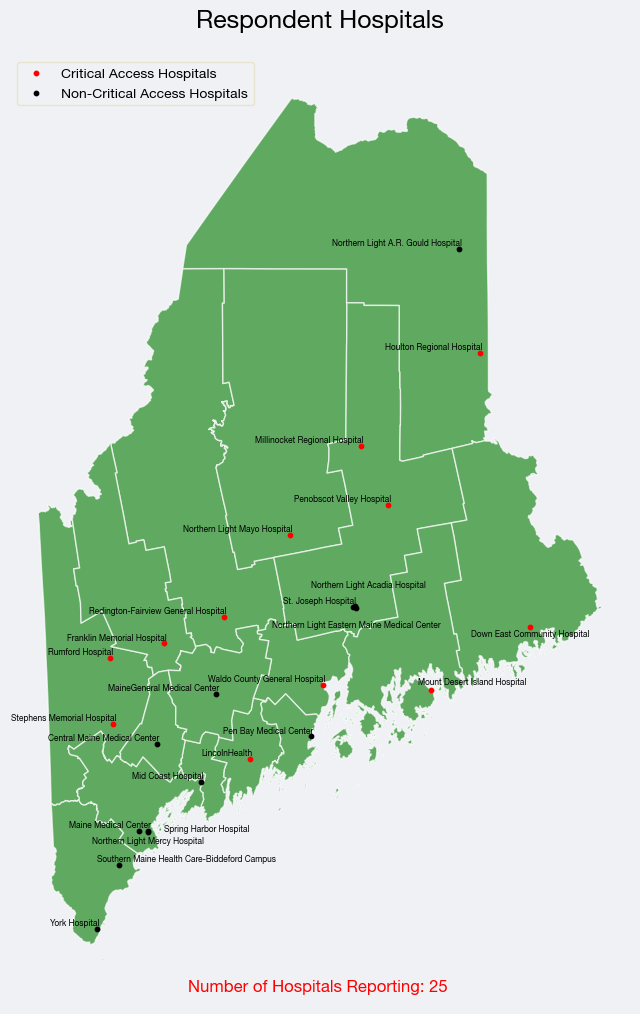

In [93]:
# Reproject hospital_gdf to match the CRS of maine_counties
hospital_gdf = hospital_gdf.to_crs(maine_counties.crs)
num_reporting = hospital_gdf.shape[0]

# Plot the regions
fig, ax = plt.subplots(figsize=(8, 13))
maine_counties.plot(column = "county",
                    color="forestgreen",
                    edgecolor="white",     
                    linewidth=1,   
                    legend=True,   
                    ax=ax,
                    alpha = 0.7)

# Separate the GeoDataFrame based on the condition
critical_hospitals = hospital_gdf[
    hospital_gdf["Is your facility designated a Critical Access Hospital? Response"] == "Yes"
]
non_critical_hospitals = hospital_gdf[
    hospital_gdf["Is your facility designated a Critical Access Hospital? Response"] == "No"
]

# Overlay Critical Access Hospitals with "o" marker
critical_hospitals.plot(
    ax=ax,
    edgecolor="red",
    color="red",
    marker="o",           # Circle marker
    label="Critical Access Hospitals",
    markersize=10
)

# Overlay Non-Critical Access Hospitals with "x" marker
non_critical_hospitals.plot(
    ax=ax,
    edgecolor="black",
    color="black",
    marker="o",           # Cross marker
    label="Non-Critical Access Hospitals",
    markersize=10
)

# Add hospital names; adjusting alignment of some
for x, y, label in zip(hospital_gdf.geometry.x, hospital_gdf.geometry.y, hospital_gdf['hospital_name']):

    if label == "Northern Light Acadia Hospital":
        ax.text(x + 0.1, y + 0.1, label, fontsize=6, weight="bold", ha='center', color='black')  
        
    elif label == "Northern Light Eastern Maine Medical Center":
        ax.text(x, y - 0.1, label, fontsize=6, weight="bold", ha='center', color='black') 

    elif label == "Down East Community Hospital":
        ax.text(x, y - 0.05, label, fontsize=6, weight="bold", ha='center', color='black') 

    elif label == "Northern Light Mercy Hospital":
        ax.text(x, y - 0.06, label, fontsize=6, weight="bold", ha='center', color='black')  

    elif label == "Spring Harbor Hospital":
        ax.text(x + 0.5, y, label, fontsize=6, weight="bold", ha='center', color='black')  

    elif label == "Mount Desert Island Hospital":
        ax.text(x + 0.3, y + 0.03, label, fontsize=6, weight="bold", ha='center', color='black') 

    elif label == "Southern Maine Health Care-Biddeford Campus":
        print("HERE")
        ax.text(x + 0.5, y + 0.02, label, fontsize=6, weight="bold", ha='center', color='black')                             
    else:       
        ax.text(x + 0.02, y + 0.02, label, fontsize=6, weight = 'bold', ha='right', color='black')

# Add the grand total to the bottom
fig.text(
            0.51, 0.15,
            f"Number of Hospitals Reporting: {num_reporting}",
            ha = "center", 
            fontsize = 12, 
            color="red", 
            weight="bold"
        )

# Legend and title
plt.title("Respondent Hospitals", weight="bold")
plt.legend(
    loc="upper left",  
    fontsize=10         
)
ax.axis("off")
fig.savefig("../figs/hospital_locations.png", dpi = 300, bbox_inches="tight")
plt.show();

### Map the Hospitals to Counties

In [94]:
# Maps the hospitals to their respective counties based on the lat and long
mapped_hospitals = gpd.sjoin(hospital_gdf, maine_counties, how = "left", predicate = "within")

In [95]:
mapped_hospitals.head()

,hospital_name,lat,long,Is your facility designated a Critical Access Hospital? Response,geometry,index_right,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,...,county,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,region,region_color,color
0,Central Maine Medical Center,44.102600,-70.214693,No,POINT (-70.21469 44.10260),2626,23,001,00581286,0500000US23001,...,Androscoggin,Androscoggin County,ME,Maine,06,1211995418,75541705,3,#a3e4d7,#f5b7b1
1,Penobscot Valley Hospital,45.347570,-68.517546,Yes,POINT (-68.51755 45.34757),1925,23,019,00581295,0500000US23019,...,Penobscot,Penobscot County,ME,Maine,06,8798661091,414021728,6,#f1948a,#d5a6bd
2,Franklin Memorial Hospital,44.626380,-70.162782,Yes,POINT (-70.16278 44.62638),911,23,007,00581289,0500000US23007,...,Franklin,Franklin County,ME,Maine,06,4395226704,121284631,2,#c39bd3,#f8c471
3,Northern Light Mayo Hospital,45.187687,-69.237320,Yes,POINT (-69.23732 45.18769),541,23,021,00581296,0500000US23021,...,Piscataquis,Piscataquis County,ME,Maine,06,10258545867,1080517302,6,#f1948a,#fad7a0
4,Rumford Hospital,44.551829,-70.556196,Yes,POINT (-70.55620 44.55183),52,23,017,00581294,0500000US23017,...,Oxford,Oxford County,ME,Maine,06,5379294383,255884970,2,#c39bd3,#a3e4d7


In [96]:
mapped_hospitals.rename(columns = {"NAME": "county"}, inplace = True)

In [97]:
hospital_counties_and_region = mapped_hospitals[["hospital_name", "county", "region"]]

In [98]:
hospital_counties_and_region

,hospital_name,county,region
0,Central Maine Medical Center,Androscoggin,3
1,Penobscot Valley Hospital,Penobscot,6
2,Franklin Memorial Hospital,Franklin,2
3,Northern Light Mayo Hospital,Piscataquis,6
4,Rumford Hospital,Oxford,2
5,Millinocket Regional Hospital,Penobscot,6
6,Waldo County General Hospital,Waldo,4
7,York Hospital,York,1
8,Northern Light Mercy Hospital,Cumberland,1
9,Mid Coast Hospital,Cumberland,1


___
### Filter Response Data & Generate Grouped DF

In this section we can make some groupings and generate choropleths by region and by county.
The function below can make choropleths with data grouped by region and by county.

In [127]:
def generate_grouped_choropleth(grouped_df:pd.DataFrame, county_gis_df:pd.DataFrame, grouping_col:str, dissolve_flag:bool = False, setting_df:pd.DataFrame = None,
                                title:str = None, save_path:str = None) -> None:
    """
    Genreates a choropleth using a grouped dataframe. 
    """
    # Get the grand total
    grand_total = int(grouped_df.sum())

    # Convert grouping_col to string; regions are currently ints
    maine_counties[grouping_col] = maine_counties[grouping_col].astype(str)
    grouped_df.index = grouped_df.index.astype(str)

    # Merge grouped_df and GIS df
    map_data = county_gis_df.merge(grouped_df, on = grouping_col, how = "left")
    map_data["log_transform"] = map_data["total"].map(lambda x: np.log(x) if x > 0 else 0) 

    # Genreate Choropleth
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    fig.suptitle(title, weight = "bold", fontsize = 18)
    map_data.plot(column="log_transform", cmap = "Greens", linewidth = 0.8, ax = ax, edgecolor = "0.8", legend = False, alpha = 0.7)

    # If the dissolve flag is true, we generate new borders by region
    if dissolve_flag:

        # This changes the borders from county to region; the agg function makes it keep only one of the values,
        # rather than a sum. Since grouped_df already contains region totals, this is accurate.
        region_geometries = map_data.dissolve(by='region', aggfunc = {'total': 'first'})

        # Display totals in the center of the region
        for idx, row in region_geometries.iterrows():
            if not pd.isna(row['total']):  

                # Get the center of the region
                centroid = row['geometry'].centroid
                x, y = centroid.x, centroid.y
                ax.text(
                    x, y,
                    f"{int(row['total'])}",
                    ha="center", fontsize=10, color = "black", weight="bold"
                )                               
    # When the dissolve flag is false, we are grouping by county and keep the original boundaries.
    else:
        for idx, row in map_data.iterrows():
            if not pd.isna(row['total']):  

                # Get the center of the county
                centroid = row['geometry'].centroid
                x, y = centroid.x, centroid.y
                ax.text(
                    x, y,
                    f"{int(row['total'])}",
                    ha="center", fontsize=10, color="black", weight="bold"
                )      
    
        # Add the grand total to the bottom
    fig.text(
                0.5, 0.93,
                f"Statewide Total: {int(grand_total)}",
                ha = "center", 
                fontsize = 12, 
                color="red", 
                weight="bold"
            )
    if setting_df is not None:

        plt.subplots_adjust(bottom=0.2)
        ax2 = fig.add_axes([0.5, 0.05, 0.20, 0.1])  
        ax2.set_title("Totals by Destination", weight = "bold", style = "italic", fontsize = 14)
        bars = ax2.barh(setting_df.index, setting_df["count"], color = setting_df["color"], alpha = 0.8)
        
        # Annotate bars
        for bar in bars:
            width = bar.get_width()  # Get the width of the bar
            y = bar.get_y() + bar.get_height() / 2  # Get the center of the bar
            ax2.text(
                width + 1, y,  # Position 
                f"{int(width)}",  # Annotation 
                va="center", ha="left", fontsize=10, fontweight="bold"
            )
        ax2.set_xticks([])
        ax2.tick_params(axis='y', length=0)
        plt.setp(ax2.get_yticklabels(), fontweight="bold")

    # Add title
    ax.axis("off")
    plt.tight_layout()
    fig.savefig(save_path, dpi = 300, bbox_inches="tight")


In [126]:
def generate_grouped_pad_map(grouped_df:pd.DataFrame, county_gis_df:pd.DataFrame, grouping_col:str, dissolve_flag:bool = False, setting_df:pd.DataFrame = None,
                                title:str = None, save_path:str = None) -> None:
    """
    Genreates a choropleth using a grouped dataframe. 
    """
    # Get the grand total
    grand_total = int(grouped_df.sum())

    # Convert grouping_col to string; regions are currently ints
    maine_counties[grouping_col] = maine_counties[grouping_col].astype(str)
    grouped_df.index = grouped_df.index.astype(str)

    # Merge grouped_df and GIS df
    map_data = county_gis_df.merge(grouped_df, on = grouping_col, how = "left")
    map_data["log_transform"] = map_data["total"].map(lambda x: np.log(x) if x > 0 else 0) 

    # Genreate Choropleth
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    fig.suptitle(title, weight = "bold", fontsize = 18)
    map_data.plot(column="log_transform", color = "forestgreen", linewidth = 0.8, ax = ax, edgecolor = "0.8", legend = False, alpha = 0.7)

    # If the dissolve flag is true, we generate new borders by region
    if dissolve_flag:

        # This changes the borders from county to region; the agg function makes it keep only one of the values,
        # rather than a sum. Since grouped_df already contains region totals, this is accurate.
        region_geometries = map_data.dissolve(by='region', aggfunc = {'total': 'first'})

        # Display totals in the center of the region
        for idx, row in region_geometries.iterrows():
            if not pd.isna(row['total']):  

                # Get the center of the region
                centroid = row['geometry'].centroid
                x, y = centroid.x, centroid.y
                ax.text(
                    x, y,
                    f"{int(row['total'])}",
                    ha="center", fontsize=10, color = "red", weight="bold"
                )                               
    # When the dissolve flag is false, we are grouping by county and keep the original boundaries.
    else:
        for idx, row in map_data.iterrows():
            if not pd.isna(row['total']):  

                # Get the center of the county
                centroid = row['geometry'].centroid
                x, y = centroid.x, centroid.y
                ax.text(
                    x, y,
                    f"{int(row['total'])}",
                    ha="center", fontsize=10, color="red", weight="bold"
                )      
    
        # Add the grand total to the bottom
    fig.text(
                0.5, 0.93,
                f"Statewide Total: {int(grand_total)}",
                ha = "center", 
                fontsize = 12, 
                color="red", 
                weight="bold"
            )
    if setting_df is not None:

        plt.subplots_adjust(bottom=0.2)
        ax2 = fig.add_axes([0.5, 0.05, 0.20, 0.1])  
        ax2.set_title("Totals by Destination", weight = "bold", style = "italic", fontsize = 14)
        bars = ax2.barh(setting_df.index, setting_df["count"], color = setting_df["color"], alpha = 0.8)
        
        # Annotate bars
        for bar in bars:
            width = bar.get_width()  # Get the width of the bar
            y = bar.get_y() + bar.get_height() / 2  # Get the center of the bar
            ax2.text(
                width + 1, y,  # Position 
                f"{int(width)}",  # Annotation 
                va="center", ha="left", fontsize=10, fontweight="bold"
            )
        ax2.set_xticks([])
        ax2.tick_params(axis='y', length=0)
        plt.setp(ax2.get_yticklabels(), fontweight="bold")

    # Add title
    ax.axis("off")
    plt.tight_layout()
    fig.savefig(save_path, dpi = 300, bbox_inches="tight")

### Filter for Question # 1

In [101]:
response_data_full.iloc[0:5, 12:16]

,Total number of patients awaiting discharge to the following settings: Skilled Nursing Facility (SNF):,Total number of patients awaiting discharge to the following settings: Long Term Care Hospital (LTC):,Total number of patients awaiting discharge to the following settings: Residential Care Facility (RCF):,Total number of patients awaiting discharge to the following settings: Home Health:
0,3.0,3.0,1.0,5.0
1,0.0,0.0,0.0,1.0
2,NaN,2.0,1.0,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [102]:
snf_col = "Total number of patients awaiting discharge to the following settings: Skilled Nursing Facility (SNF):"
ltc_col = "Total number of patients awaiting discharge to the following settings: Long Term Care Hospital (LTC):"
rcf_col = "Total number of patients awaiting discharge to the following settings: Residential Care Facility (RCF):"
hh_col = "Total number of patients awaiting discharge to the following settings: Home Health:"

In [103]:
# Filter for question # 1 ~ Totals
question_1_responses = response_data_full.loc[:, ["hospital_name", snf_col, ltc_col, rcf_col, hh_col]]
question_1_responses

,hospital_name,Total number of patients awaiting discharge to the following settings: Skilled Nursing Facility (SNF):,Total number of patients awaiting discharge to the following settings: Long Term Care Hospital (LTC):,Total number of patients awaiting discharge to the following settings: Residential Care Facility (RCF):,Total number of patients awaiting discharge to the following settings: Home Health:
0,Central Maine Medical Center,3.0,3.0,1.0,5.0
1,Penobscot Valley Hospital,0.0,0.0,0.0,1.0
2,Franklin Memorial Hospital,NaN,2.0,1.0,NaN
3,Northern Light Mayo Hospital,NaN,NaN,NaN,NaN
4,Rumford Hospital,NaN,NaN,NaN,NaN
5,Millinocket Regional Hospital,1.0,0.0,0.0,3.0
6,Northern Light Acadia Hospital,NaN,NaN,NaN,NaN
7,Pen Bay Medical Center,4.0,5.0,4.0,2.0
8,Waldo County General Hospital,3.0,3.0,1.0,2.0
9,York Hospital,3.0,1.0,0.0,0.0


In [104]:
question_1_responses["total"] = question_1_responses.iloc[:, 1:5].sum(axis = 1, skipna = True)

In [105]:
settings_totals = question_1_responses.sum(axis = 0)

In [106]:
settings_totals

hospital_name                                                                                              Central Maine Medical CenterPenobscot Valley H...
Total number of patients awaiting discharge to the following settings: Skilled Nursing Facility (SNF):                                                 108.0
Total number of patients awaiting discharge to the following settings: Long Term Care Hospital (LTC):                                                   78.0
Total number of patients awaiting discharge to the following settings: Residential Care Facility (RCF):                                                 38.0
Total number of patients awaiting discharge to the following settings: Home Health:                                                                     74.0
total                                                                                                                                                  298.0
dtype: object

In [107]:
setting_df = pd.DataFrame(settings_totals).loc[[snf_col, ltc_col, rcf_col, hh_col], :]

In [108]:
setting_df.index = ["SNF", "LTC", "RCF", "HH"]

In [109]:
setting_df.rename(columns = {0:"count"}, inplace = True)

In [113]:
setting_df["color"] = setting_df.index.map(facility_colors_acronym)

In [ ]:
setting_df

,count,color
SNF,108.0,#ff7f0e
LTC,78.0,#2ca02c
RCF,38.0,#d62728
HH,74.0,#1f77b4


In [114]:
setting_df["count"] = pd.to_numeric(setting_df["count"], errors="coerce")


In [115]:
question_1_responses = question_1_responses[["hospital_name", "total"]]

In [116]:
question_1_responses_with_counties = question_1_responses.merge(hospital_counties_and_region, left_on = "hospital_name", right_on = "hospital_name", how = "right")

In [117]:
question_1_responses_with_counties.rename(columns = {"NAME": "county"}, inplace = True)

### Group Question # 1 by Region

In [118]:
grouped_by_region_df = question_1_responses_with_counties.groupby("region")["total"].sum()
grouped_by_region_df

region
1    118.0
2      3.0
3     40.0
4     27.0
5      9.0
6     91.0
7     10.0
Name: total, dtype: float64

/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_59754/1177423848.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


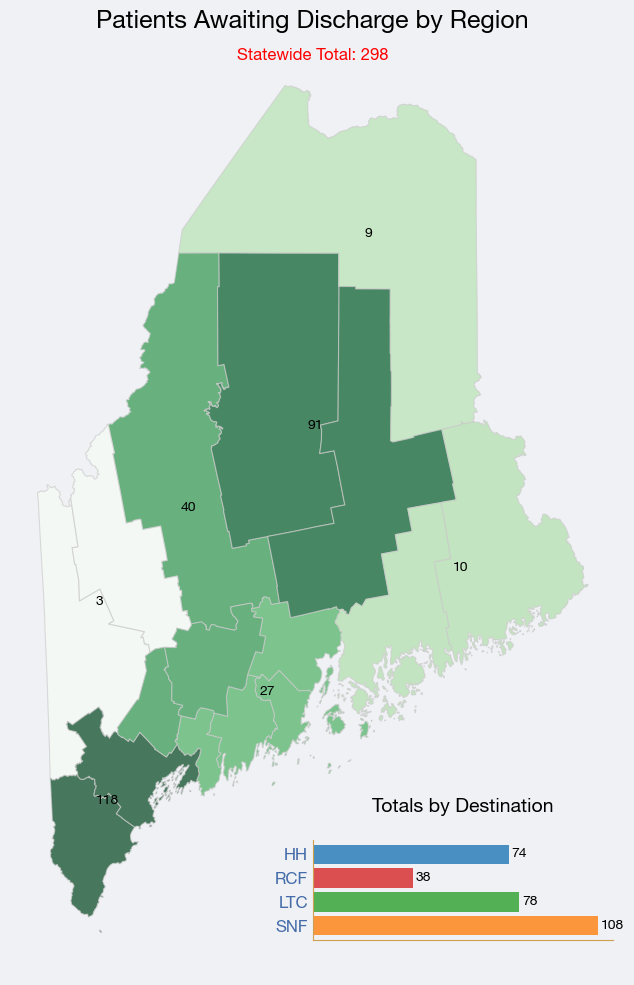

In [128]:
fig_title = "Patients Awaiting Discharge by Region"
save_path = "../figs/patients_awaiting_discharge_region.png"
generate_grouped_choropleth(grouped_by_region_df, maine_counties, "region", True, setting_df, fig_title, save_path)

### Group Question # 1 by County

In [129]:
grouped_by_county_df = question_1_responses_with_counties.groupby("county")["total"].sum()
grouped_by_county_df

county
Androscoggin     12.0
Aroostook         9.0
Cumberland      114.0
Franklin          3.0
Hancock           5.0
Kennebec         22.0
Knox             15.0
Lincoln           3.0
Oxford            0.0
Penobscot        91.0
Piscataquis       0.0
Somerset          6.0
Waldo             9.0
Washington        5.0
York              4.0
Name: total, dtype: float64

In [130]:
print(len(grouped_by_county_df))

15


### Add Sagadahoc County  
Sagadahoc County has not reporting hospitals and will therefore have no value in the figure.  
Here we will manually add 0 for Sagadahoc County.

In [131]:
grouped_by_county_df["Sagadahoc"] = 0.0


In [132]:
print(len(grouped_by_county_df))

16


/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_59754/1177423848.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


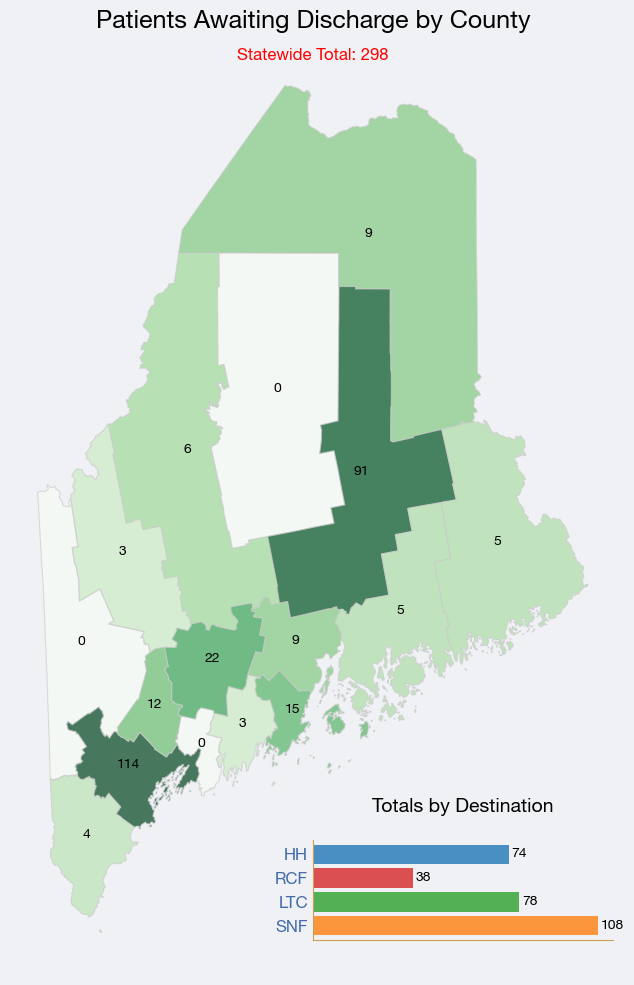

In [133]:
fig_title = "Patients Awaiting Discharge by County"
save_path = "../figs/patients_awaiting_discharge_county.png"
generate_grouped_choropleth(grouped_by_county_df, maine_counties, "county", False, setting_df, fig_title, save_path)

/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_59754/2230980184.py:20: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  map_data.plot(column="log_transform", color = "forestgreen", linewidth = 0.8, ax = ax, edgecolor = "0.8", legend = False, alpha = 0.7)
/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_59754/2230980184.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


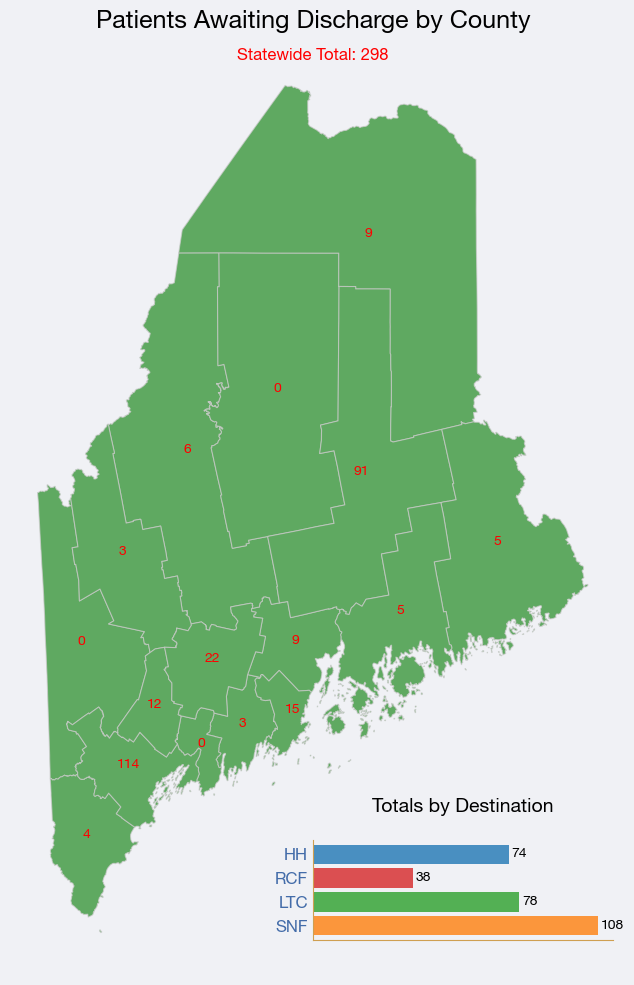

In [134]:
fig_title = "Patients Awaiting Discharge by County"
save_path = "../figs/patients_awaiting_discharge_county_.png"
generate_grouped_pad_map(grouped_by_county_df, maine_counties, "county", False, setting_df, fig_title, save_path)

### Patients Awaiting Discharge by Hospital with Nursing Home Closures

In [135]:
# Read in the closures csv
closures_df = pd.read_csv("../gis_data/nh_closures.csv")

In [136]:
closures_df

,nursing_home,lat,long
0,Falmouth by the Sea,43.72738,-70.21291
1,Evergreen Rehab & Living Center,44.02544,-69.80437
2,Bridgton Health & Residential Care Center,44.04205,-70.69843
3,Freeport Nursing & Rehabilitation Center,43.83336,-70.13425
4,Fryeburg Health Care Center,44.02761,-70.96408
5,Ledgeview Living Center,44.32762,-70.55169
6,Heritage Rehabilitation & Living Center,44.28815,-70.00324
7,Quarry Hill Retirement Community/The Gardens,44.19947,-69.07401
8,Knox Center for Long Term Care,44.10527,-69.11307
9,Country Manor Nursing Home,44.25989,-69.55421


In [137]:
# Convert combined_df to GeoDataFrame
nursing_home_gdf = gpd.GeoDataFrame(
    closures_df,
    geometry=[Point(xy) for xy in zip(closures_df['long'], closures_df['lat'])],
    crs='EPSG:4326')  # WGS84 CRS for latitude/longitude

In [138]:
hospital_gdf = mapped_hospitals.merge(question_1_responses, left_on = "hospital_name", right_on = "hospital_name")

/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_59754/147783881.py:18: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  maine_counties.plot(ax=ax,


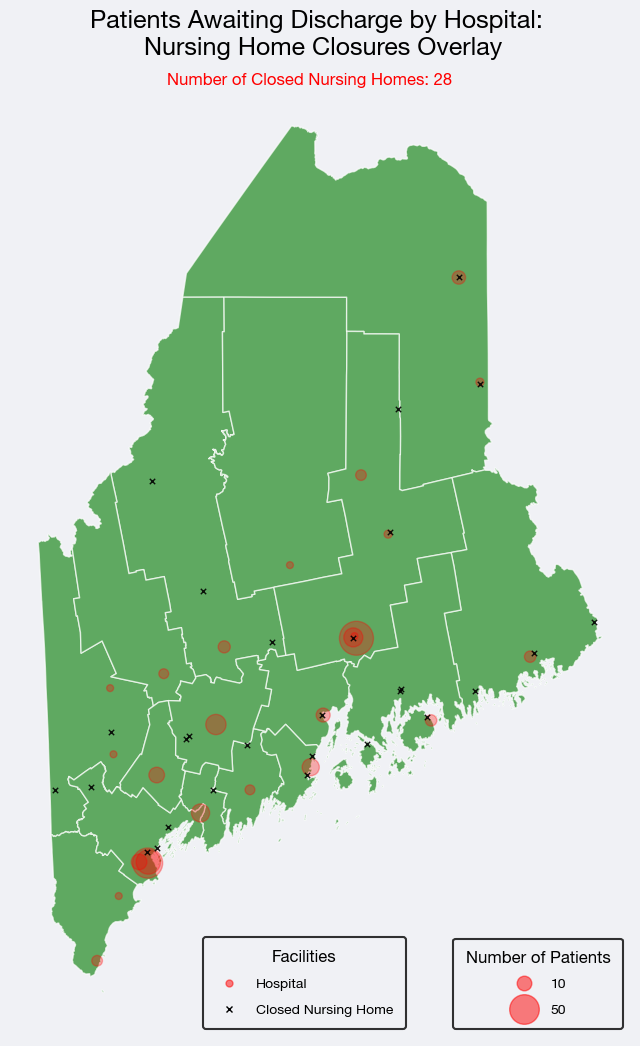

In [141]:
# Reproject hospital_gdf and nursing_home_gdf to match the CRS of maine_counties
hospital_gdf = hospital_gdf.to_crs(maine_counties.crs)
nursing_home_gdf = nursing_home_gdf.to_crs(maine_counties.crs)

# Get the number of closed nursing homes
num_closed_nh = nursing_home_gdf.shape[0]

# Normalize the marker size column for consistent scaling
size_min, size_max = 25, 600  # Minimum and maximum marker sizes
hospital_gdf["scaled_size"] = (
    (hospital_gdf["total"] - hospital_gdf["total"].min())
    / (hospital_gdf["total"].max() - hospital_gdf["total"].min())
    * (size_max - size_min) + size_min
)

# Plot the regions
fig, ax = plt.subplots(figsize=(8, 13))
maine_counties.plot(ax=ax, 
                    column = "county", 
                    edgecolor="white",      # Boundary color
                    linewidth=1,   
                    color="forestgreen", alpha=0.7)
 
# Overlay the hospital locations with semi-transparent markers and variable sizes
hospital_gdf.plot(
    ax=ax,
    color='red',
    marker='o',
    markersize=hospital_gdf["scaled_size"],
    alpha=0.3,
    label = "Hospital"
)

# Overlay the hospital locations with semi-transparent markers and variable sizes
nursing_home_gdf.plot(
    ax=ax,
    color='black',
    marker='x',
    markersize=15,
    alpha=0.9,
    label = "Closed Nursing Home"
)

# Add the grand total to the bottom
fig.text(
            0.5, 0.87,
            f"Number of Closed Nursing Homes: {int(num_closed_nh)}",
            ha = "center", 
            fontsize = 12, 
            color="red", 
            weight="bold",
            style = "italic"
        )

# Add a custom legend for dot sizes
reference_totals = [10, 50]  # Example hospital "total" values
reference_sizes = [
    (total - hospital_gdf["total"].min())
    / (hospital_gdf["total"].max() - hospital_gdf["total"].min())
    * (size_max - size_min) + size_min
    for total in reference_totals
]

# Create legend handles with adjusted sizes for the legend box
handles = [
    mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                  markersize=size**0.5, alpha=0.5, label=f'{total}')
    for total, size in zip(reference_totals, reference_sizes)
]

# Create legend handles for hospitals and nursing homes
hospital_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                                markersize=5, label='Hospital', alpha = 0.5)
nursing_home_handle = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                                    markersize=5, label='Closed Nursing Home')

# Add the legend for the sizes
legend = ax.legend(
    handles= handles, 
    title="Number of Patients", 
    loc='lower right',
    frameon = True, # Add the border 
    borderpad=0.9,  # Increase padding inside the legend box
    labelspacing=0.9,  # Increase space between labels
    handletextpad=0.9,  # Increase space between markers and text
    fontsize=10  # Adjust font size
)

# Customize Legend
legend.get_title().set_fontweight("bold") # Set the legend title to bold
legend.get_frame().set_linewidth(1.5)  # Set the border thickness
legend.get_frame().set_edgecolor('black')

facility_legend = ax.legend(
    handles=[hospital_handle, nursing_home_handle],
    title="Facilities",
    loc='lower left',
    frameon=True,
    fontsize=10,
    bbox_to_anchor=(0.3, 0.00),  # Adjusts position relative to the plot
    borderpad=0.9,
    labelspacing=0.95,
    handletextpad=0.9
)

# Customize Legend
facility_legend.get_title().set_fontweight("bold") # Set the legend title to bold
facility_legend.get_frame().set_linewidth(1.5)  # Set the border thickness
facility_legend.get_frame().set_edgecolor('black')

ax.add_artist(legend)

# Title and axis adjustments
plt.title("Patients Awaiting Discharge by Hospital: \n Nursing Home Closures Overlay", weight="bold", fontsize = 18)
ax.axis("off")
fig.savefig("../figs/pad_by_hospital.png", dpi = 300, bbox_inches="tight")
plt.show()

### Filter for Emergency Department Questions

In [142]:
# Filter for emergency department questions
emergency_data = response_data_full.iloc[:, 96:107].copy()
emergency_data["hospital_name"] = response_data_full["hospital_name"]

# Move hosptial name to the front; fuck it why not
columns = list(emergency_data.columns)
last_col = columns[-1] 
new_order = [last_col] + columns[:-1]  # Reorder columns
emergency_data = emergency_data[new_order]

# Display the resulting DataFrame
emergency_data.head()

,hospital_name,How many licensed ED beds are in your hospital? Open-Ended Response,How many of your licensed ED beds are staffed in your hospital? Open-Ended Response,How many patients are currently in your ED? Open-Ended Response,"Of those patients reported in question 3, how many are age 17 or younger? Open-Ended Response","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 48 hours","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: >48 hours but less than one week","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 7 to 14 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 15 to 30 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 31 to 60 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 61 to 120 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: >3 months"
0,Central Maine Medical Center,48.0,36.0,24.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Penobscot Valley Hospital,6.0,6.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Franklin Memorial Hospital,NaN,8.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Northern Light Mayo Hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Rumford Hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Update Franklin Memorial ED Licensed Bed Count

In [143]:
emergency_data.iloc[2,1] = 25

In [144]:
emergency_data.head()

,hospital_name,How many licensed ED beds are in your hospital? Open-Ended Response,How many of your licensed ED beds are staffed in your hospital? Open-Ended Response,How many patients are currently in your ED? Open-Ended Response,"Of those patients reported in question 3, how many are age 17 or younger? Open-Ended Response","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 48 hours","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: >48 hours but less than one week","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 7 to 14 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 15 to 30 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 31 to 60 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 61 to 120 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: >3 months"
0,Central Maine Medical Center,48.0,36.0,24.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Penobscot Valley Hospital,6.0,6.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Franklin Memorial Hospital,25.0,8.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Northern Light Mayo Hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Rumford Hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merge ED Region and County Data

In [145]:
emergency_data = emergency_data.merge(hospital_counties_and_region, left_on = "hospital_name", right_on = "hospital_name")

In [146]:
emergency_data.head()

,hospital_name,How many licensed ED beds are in your hospital? Open-Ended Response,How many of your licensed ED beds are staffed in your hospital? Open-Ended Response,How many patients are currently in your ED? Open-Ended Response,"Of those patients reported in question 3, how many are age 17 or younger? Open-Ended Response","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 48 hours","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: >48 hours but less than one week","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 7 to 14 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 15 to 30 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 31 to 60 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 61 to 120 days","Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: >3 months",county,region
0,Central Maine Medical Center,48.0,36.0,24.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Androscoggin,3
1,Penobscot Valley Hospital,6.0,6.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Penobscot,6
2,Franklin Memorial Hospital,25.0,8.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Franklin,2
3,Northern Light Mayo Hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Piscataquis,6
4,Rumford Hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oxford,2


In [147]:
col_1 = "How many licensed ED beds are in your hospital? Open-Ended Response"
col_2 = "How many of your licensed ED beds are staffed in your hospital? Open-Ended Response"
col_3 = "How many patients are currently in your ED? Open-Ended Response"
grouping_col = "county"
emergency_data = emergency_data.groupby(grouping_col)[[col_1, col_2, col_3]].sum().reset_index()
emergency_data = emergency_data.fillna(0) 

In [148]:
emergency_data

,county,How many licensed ED beds are in your hospital? Open-Ended Response,How many of your licensed ED beds are staffed in your hospital? Open-Ended Response,How many patients are currently in your ED? Open-Ended Response
0,Androscoggin,48.0,36.0,24.0
1,Aroostook,21.0,21.0,14.0
2,Cumberland,124.0,58.0,57.0
3,Franklin,25.0,8.0,8.0
4,Hancock,8.0,8.0,7.0
5,Kennebec,45.0,45.0,51.0
6,Knox,23.0,23.0,36.0
7,Lincoln,0.0,0.0,0.0
8,Oxford,0.0,0.0,0.0
9,Penobscot,43.0,43.0,55.0


In [149]:
maine_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,county,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,region,region_color,color
51,23,015,00581293,0500000US23015,23015,Lincoln,Lincoln County,ME,Maine,06,1180688993,631299424,"MULTIPOLYGON (((-69.32357 43.75899, -69.32114 ...",4,#7dcea0,#f7dc6f
52,23,017,00581294,0500000US23017,23017,Oxford,Oxford County,ME,Maine,06,5379294383,255884970,"POLYGON ((-71.08000 45.30699, -71.07841 45.306...",2,#c39bd3,#a3e4d7
195,23,023,00581297,0500000US23023,23023,Sagadahoc,Sagadahoc County,ME,Maine,06,657801805,300571247,"MULTIPOLYGON (((-69.76031 43.71044, -69.75904 ...",4,#7dcea0,#bb8fce
432,23,027,00581299,0500000US23027,23027,Waldo,Waldo County,ME,Maine,06,1890642742,317988397,"MULTIPOLYGON (((-68.94229 44.28436, -68.94063 ...",4,#7dcea0,#aed6f1
435,23,025,00581298,0500000US23025,23025,Somerset,Somerset County,ME,Maine,06,10163811939,437942552,"POLYGON ((-70.55279 45.66784, -70.54730 45.666...",3,#a3e4d7,#5ddfce
541,23,021,00581296,0500000US23021,23021,Piscataquis,Piscataquis County,ME,Maine,06,10258545867,1080517302,"POLYGON ((-69.83118 45.73860, -69.82943 45.738...",6,#f1948a,#fad7a0
710,23,031,00581301,0500000US23031,23031,York,York County,ME,Maine,06,2567186511,721352437,"MULTIPOLYGON (((-70.61725 42.99202, -70.61467 ...",1,#85c1e9,#c39bd3
911,23,007,00581289,0500000US23007,23007,Franklin,Franklin County,ME,Maine,06,4395226704,121284631,"POLYGON ((-70.83554 45.29380, -70.82755 45.296...",2,#c39bd3,#f8c471
1287,23,003,00581287,0500000US23003,23003,Aroostook,Aroostook County,ME,Maine,06,17278162809,405078327,"POLYGON ((-70.01975 46.59217, -69.99709 46.695...",5,#f8c471,#abebc6
1925,23,019,00581295,0500000US23019,23019,Penobscot,Penobscot County,ME,Maine,06,8798661091,414021728,"POLYGON ((-69.35567 45.07347, -69.24996 45.087...",6,#f1948a,#d5a6bd


In [150]:
# Convert grouping_col to string; regions are currently ints
maine_counties[grouping_col] = maine_counties[grouping_col].astype(str)
emergency_data[grouping_col] = emergency_data[grouping_col].astype(str)

# Merge grouped_df and GIS df
map_data = maine_counties.merge(emergency_data, on = grouping_col, how = "left")

In [151]:
map_data = map_data.fillna(0)

In [152]:
map_data

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,county,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,region,region_color,color,How many licensed ED beds are in your hospital? Open-Ended Response,How many of your licensed ED beds are staffed in your hospital? Open-Ended Response,How many patients are currently in your ED? Open-Ended Response
0,23,015,00581293,0500000US23015,23015,Lincoln,Lincoln County,ME,Maine,06,1180688993,631299424,"MULTIPOLYGON (((-69.32357 43.75899, -69.32114 ...",4,#7dcea0,#f7dc6f,0.0,0.0,0.0
1,23,017,00581294,0500000US23017,23017,Oxford,Oxford County,ME,Maine,06,5379294383,255884970,"POLYGON ((-71.08000 45.30699, -71.07841 45.306...",2,#c39bd3,#a3e4d7,0.0,0.0,0.0
2,23,023,00581297,0500000US23023,23023,Sagadahoc,Sagadahoc County,ME,Maine,06,657801805,300571247,"MULTIPOLYGON (((-69.76031 43.71044, -69.75904 ...",4,#7dcea0,#bb8fce,0.0,0.0,0.0
3,23,027,00581299,0500000US23027,23027,Waldo,Waldo County,ME,Maine,06,1890642742,317988397,"MULTIPOLYGON (((-68.94229 44.28436, -68.94063 ...",4,#7dcea0,#aed6f1,16.0,16.0,20.0
4,23,025,00581298,0500000US23025,23025,Somerset,Somerset County,ME,Maine,06,10163811939,437942552,"POLYGON ((-70.55279 45.66784, -70.54730 45.666...",3,#a3e4d7,#5ddfce,15.0,15.0,11.0
5,23,021,00581296,0500000US23021,23021,Piscataquis,Piscataquis County,ME,Maine,06,10258545867,1080517302,"POLYGON ((-69.83118 45.73860, -69.82943 45.738...",6,#f1948a,#fad7a0,0.0,0.0,0.0
6,23,031,00581301,0500000US23031,23031,York,York County,ME,Maine,06,2567186511,721352437,"MULTIPOLYGON (((-70.61725 42.99202, -70.61467 ...",1,#85c1e9,#c39bd3,58.0,58.0,74.0
7,23,007,00581289,0500000US23007,23007,Franklin,Franklin County,ME,Maine,06,4395226704,121284631,"POLYGON ((-70.83554 45.29380, -70.82755 45.296...",2,#c39bd3,#f8c471,25.0,8.0,8.0
8,23,003,00581287,0500000US23003,23003,Aroostook,Aroostook County,ME,Maine,06,17278162809,405078327,"POLYGON ((-70.01975 46.59217, -69.99709 46.695...",5,#f8c471,#abebc6,21.0,21.0,14.0
9,23,019,00581295,0500000US23019,23019,Penobscot,Penobscot County,ME,Maine,06,8798661091,414021728,"POLYGON ((-69.35567 45.07347, -69.24996 45.087...",6,#f1948a,#d5a6bd,43.0,43.0,55.0


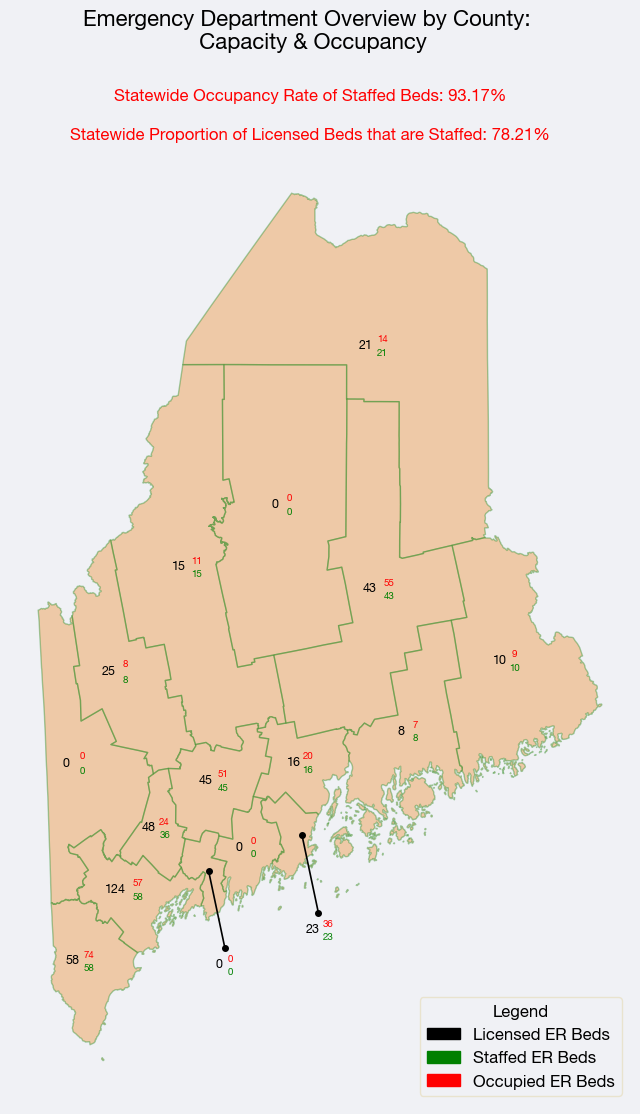

In [154]:
# Plot the regions
fig, ax = plt.subplots(figsize=(8, 13))
fig.suptitle("Emergency Department Overview by County: \n Capacity & Occupancy", weight = "bold", fontsize = 16, y = 0.98)
maine_counties.plot(
                    facecolor = "#eb8f34",
                    edgecolor = "forestgreen",
                    alpha = 0.4,
                    legend=True,   
                    ax=ax,
                    )

statewide_occupancy_rate = map_data[col_2].sum() / map_data[col_3].sum()
proportion_licensed_staffed = map_data[col_2].sum() / map_data[col_1].sum()

for idx, row in map_data.iterrows():
    if not pd.isna(row[grouping_col]):  

        # Get the center of the region
        centroid = row['geometry'].centroid
        x, y = centroid.x, centroid.y
        
        if row[grouping_col] == "Oxford":
            ax.text(
                x - 0.12, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x, y - .04,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x, y + .04,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            )
        elif row[grouping_col] == "Franklin":
            ax.text(
                x - 0.12, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x, y - .04,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x, y + .04,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            )
        elif row[grouping_col] == "York":
            ax.text(
                x - 0.12, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x, y - 0.035,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x, y + 0.035,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            ) 
        elif row[grouping_col] == "Cumberland":
            ax.text(
                x - 0.12, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x + 0.05, y - 0.035,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x + 0.05, y + 0.035,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            )  
        elif row[grouping_col] == "Androscoggin":
            ax.text(
                x - 0.065, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x + 0.05, y - 0.035,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x + 0.05, y + 0.035,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            )   
        elif row[grouping_col] == "Sagadahoc": ###########################

            ax.plot(
                [x + 0.02, x + 0.14],  # x-coordinates: from centroid to text
                [y, y - 0.40],  # y-coordinates: from centroid to text
                color="black", linewidth=1.2, linestyle="-"  # Line style
                )
            ax.text(
                x + 0.1, y - 0.5,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x + 0.18, y - 0.535,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x + 0.18, y - 0.47,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            ) 
        elif row[grouping_col] == "Lincoln":
            ax.text(
                x - 0.065, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x + 0.04, y - 0.035,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x + 0.04, y + 0.035,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            )   
        elif row[grouping_col] == "Somerset":
            ax.text(
                x - 0.095, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x + 0.04, y - 0.035,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x + 0.04, y + 0.035,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            )
        elif row[grouping_col] == "Kennebec":
            ax.text(
                x - 0.085, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x + 0.04, y - 0.035,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x + 0.04, y + 0.035,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            )
        elif row[grouping_col] == "Aroostook":
            ax.text(
                x - 0.085, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x + 0.04, y - 0.035,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x + 0.04, y + 0.035,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            )
        elif row[grouping_col] == "Penobscot":
            ax.text(
                x, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x + 0.14, y - 0.035,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x + 0.14, y + 0.035,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            )
        elif row[grouping_col] == "Knox": 

            ax.plot(
                [x + 0.02, x + 0.14], 
                [y, y - 0.40],  
                color="black", linewidth=1.2, linestyle="-" 
                )
            ax.text(
                x + 0.1, y - 0.5,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x + 0.21, y - 0.535,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x + 0.21, y - 0.47,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            ) 
        else:
            ax.text(
                x - 0.065, y,
                f"{int(row[col_1])}",
                ha="center", fontsize=9, color = "black", weight="bold"
            )
            ax.text(
                x + 0.04, y - 0.035,
                f"{int(row[col_2])}",
                ha="center", fontsize=7, color = "green", weight="bold"
            )
            ax.text(
                x + 0.04, y + 0.035,
                f"{int(row[col_3])}",
                ha="center", fontsize=7, color = "red", weight="bold"
            )   
# Add the grand total to the bottom
fig.text(
            0.5, 0.91,
            f"Statewide Occupancy Rate of Staffed Beds: {(statewide_occupancy_rate * 100):.2f}%",
            ha = "center", 
            fontsize = 12, 
            color="red", 
            weight="bold",
            style = "italic"
        )

# Add the grand total to the bottom
fig.text(
            0.5, 0.88,
            f"Statewide Proportion of Licensed Beds that are Staffed: {(proportion_licensed_staffed * 100):.2f}%",
            ha = "center", 
            fontsize = 12, 
            color="red", 
            weight="bold",
            style = "italic"
        )

# Create custom legend handles for text colors
legend_handles = [
    mpatches.Patch(color='black', label='Licensed ER Beds'),
    mpatches.Patch(color='green', label='Staffed ER Beds'),
    mpatches.Patch(color='red', label='Occupied ER Beds')
]

# Add the legend for text colors
legend = plt.legend(
    handles=legend_handles,
    title="Legend",
    loc="lower right"
)

# Set the legend title to bold
legend.get_title().set_fontweight("bold")
ax.axis("off")

fig.savefig("../figs/emergency_dept_overview.png", dpi = 300, bbox_inches="tight");


In [ ]:
total_under_17 = "Of those patients reported in question 3, how many are age 17 or younger? Open-Ended Response"
more_than_48 = "Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 48 hours"	
more_48_less_7d = "Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: >48 hours but less than one week"	
seven_to_14 = "Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 7 to 14 days"	
fifteen_to_30 = "Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 15 to 30 days"	 
month_to_60d = "Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 31 to 60 days" 
sixty_days_to_120 = "Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: 61 to 120 days" 
greater_3m = "Of those patients aged 17 or younger, how many have been boarding in your emergency department for more than: >3 months"

In [ ]:
cols_of_interest = [more_than_48, more_48_less_7d, seven_to_14, fifteen_to_30, month_to_60d, sixty_days_to_120, greater_3m]

In [ ]:
emergency_data

,county,How many licensed ED beds are in your hospital? Open-Ended Response,How many of your licensed ED beds are staffed in your hospital? Open-Ended Response,How many patients are currently in your ED? Open-Ended Response
0,Androscoggin,48.0,36.0,24.0
1,Aroostook,21.0,21.0,14.0
2,Cumberland,124.0,58.0,57.0
3,Franklin,25.0,8.0,8.0
4,Hancock,8.0,8.0,7.0
5,Kennebec,45.0,45.0,51.0
6,Knox,23.0,23.0,36.0
7,Lincoln,0.0,0.0,0.0
8,Oxford,0.0,0.0,0.0
9,Penobscot,43.0,43.0,55.0


In [ ]:
grouped__u17 = emergency_data.groupby("region")[cols_of_interest].sum().reset_index()

KeyError: 'region'

In [ ]:
grouped__u17

In [ ]:
grouped__u17

In [ ]:
print(f"The total under 17: {emergency_data[total_under_17].sum()}")

In [ ]:
a = "> 48 Hrs."
b = "> 48 Hrs. < 7 Days"
c = "7 to 14 Days"
d = "15 to 30 Days"
e = "31 to 60 Days"
f = "61 to 120 Days"
g = "> 3 Months"


In [ ]:
grouped__u17.rename(columns = {more_than_48 : a,
                               more_48_less_7d: b,
                               seven_to_14: c,
                               fifteen_to_30: d,
                               month_to_60d: e,
                               sixty_days_to_120:f,
                               greater_3m: g}, inplace = True)

In [ ]:
# Extract columns for stacking
columns_to_stack = [a,b,c,d,e,f,g]

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

grouped__u17.set_index("region")[columns_to_stack].plot(
        kind="bar", 
        stacked=True, 
        ax=ax, 
        color= ["green", "blue", "purple", "brown", "yellow", "orange", "red"], 
        edgecolor="black"
)

# Add title and labels
ax.set_title("Patients Under 17 In Emergency Deptpartment \n By Region", weight="bold", fontsize=14)
ax.set_ylabel("Counts", weight = "bold")
ax.set_xlabel("Region", weight = "bold")

# Add legend
ax.legend(title="Duration of Stay", bbox_to_anchor=(1.05, 1), loc="upper left")

# Rotate x-axis tick labels
ax.tick_params(axis="x", rotation=45)


# Show the plot
plt.tight_layout()
fig.savefig("../figs/ed_u17_summary.png", dpi = 300, bbox_inches="tight")
plt.show()
